In [52]:
import os
import sys
import pickle
import random
from itertools import product
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order


sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER, get_stopwords
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline
    
normalizar = CleanUp(remove_stopwords=True)

In [84]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-27.csv")
covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

In [76]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["count"] = 1
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]

users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [85]:
# print(hashtags_.columns)
# print(users_.columns)

## Informações da base de dados

In [86]:
qtd_comentarios = len(hashtags_)
qtd_positivos = len(hashtags_[hashtags_['classify'] == 'positivo'])
qtd_negativos = len(hashtags_[hashtags_['classify'] == 'negativo'])
qtd_comentarios_geolocalizados = len(hashtags_[hashtags_['username'].isin(users_['username'])])

qtd_users_geo = len(users_[users_['username'].isin(hashtags_['username'])])

print(f"Qtde. de Comentários               : {qtd_comentarios}")
print(f"Qtde. de Comentários positivos     : {qtd_positivos}, {round(qtd_positivos/qtd_comentarios*100)}%")
print(f"Qtde. de Comentários negativos     : {qtd_negativos}, {round(qtd_negativos/qtd_comentarios*100)}%")
print(f"Qtde. de Comentários geolocalizados: {qtd_comentarios_geolocalizados}, {round(qtd_comentarios_geolocalizados/qtd_comentarios*100)}%")
print("-" * 50)
print(f"Qtde. de Usuários geolocalizados   : {qtd_users_geo}")
for estado in ["SP", "RJ", "MG", "BA", "AM"]:
    qtd_users_geo_estado = len(users_[(users_['state'] == estado) & (users_['username'].isin(hashtags_['username']))])
    print(f"Qtde. de Usuários em {estado}            : {qtd_users_geo_estado}, {round(qtd_users_geo_estado/qtd_users_geo*100)}%")

Qtde. de Comentários               : 384281
Qtde. de Comentários positivos     : 125135, 33%
Qtde. de Comentários negativos     : 259146, 67%
Qtde. de Comentários geolocalizados: 122268, 32%
--------------------------------------------------
Qtde. de Usuários geolocalizados   : 88039
Qtde. de Usuários em SP            : 17349, 20%
Qtde. de Usuários em RJ            : 18145, 21%
Qtde. de Usuários em MG            : 6289, 7%
Qtde. de Usuários em BA            : 2289, 3%
Qtde. de Usuários em AM            : 1759, 2%


Exemplos de comentários com suas classificações:

In [87]:
print("Classificação|Comentário")
for idx, row in hashtags_.sample(n=10).iterrows():
    print(f"{row.classify}|{row.comment}")
    # print("-" * 10)

Classificação|Comentário
negativo|O Brasil realmente está matando o Brasil. Hoje procurei uma UBS pois estou com sintomas “leves” de Covid e sou asmático. A orientação foi tomar anti-inflamatórios e se em 10 dias os sintomas não reduzirem, fazer o teste. DEZ DIAS!!!! Da tempo de morrer e ressuscitar.  Vergonha!!
negativo|É falta de ar, é dor nas costas. Meajudameudeus
negativo|o de áries???? Citar Tweet Grande demais pra se calar @pgmiranda  · 20 de mai Sagitário!
negativo|O corona ainda não tinha me afetado, mas hoje estou com vontade de chorar com essa merda. Não por falta de roles, mas por querer que tudo volte ao normal
positivo|To meio gripada (??) Ou só com dor de garganta/amigdalite ?
negativo|Minha mãe achando que estou com corona mas é só tristeza mesmo
negativo|Em resposta a  @rochacbruno Dois motivos: 1) Já peguei o COVID-19 (e foi horrível!). 2) Minha esposa é profissional da saúde e dou apoio a ela levando e buscando do hospital. Isso não significa que saio de casa por qua

## Nuvens de palavras

Nuvem de palavras de todos os comentários na base de dados.

In [88]:
frases = " ".join([frase for frase in hashtags_["clean_comment"].tolist()])
frases_positivo = " ".join([frase for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()])

stp_words = [
    "nao", "estou", "duvida", "consigo", "twet", "ser", "vou", "fazer", "muita",
    "viru", "agora", "dessa", "ainda", "pra", "fica", "muito", "ficar", "quero",
    "mai", "passar", "assim", "citar", "resposta", "tava", "tao", "dore", "tudo",
    "voce", "gente", "dar", "outro", "falar", "ficando", "desde", "quase", "toda",
    "tanta", "acho", "deu", "fico", "faz", ""
] + get_stopwords()[0]

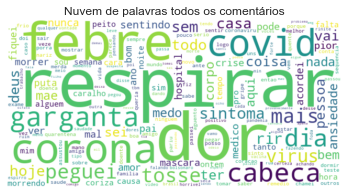

In [89]:
wordcloud = WordCloud(
    width=640, height=320,
    background_color="white", collocations=False,
    stopwords=stp_words
).generate(frases)

plt.title("Nuvem de palavras todos os comentários")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nuvens de palavras apenas de comentários classificados como positivos.

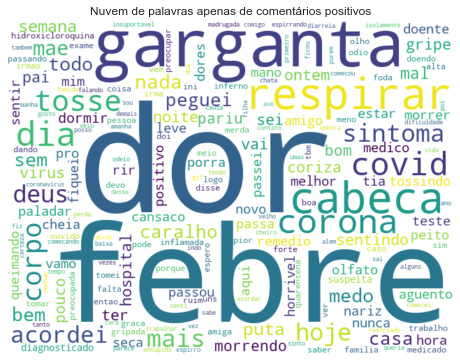

In [90]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=stp_words
).generate(frases_positivo)

plt.figure(figsize=(8, 8))
plt.title("Nuvem de palavras apenas de comentários positivos")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizações dos dados

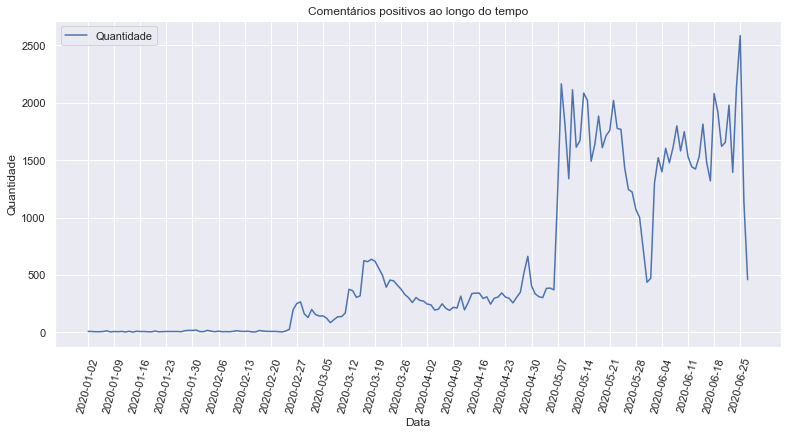

In [96]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]
df_dt = df_dt[df_dt['date'] <= pd.Timestamp(2020, 6, 27)]

steps = 7
datas = df_dt["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo
data_tempo = list(datas[::steps])

plt.figure(figsize=(13, 6))
plt.title("Comentários positivos ao longo do tempo")
plt.plot(tempo, df_dt["count"], label="Quantidade")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.show()

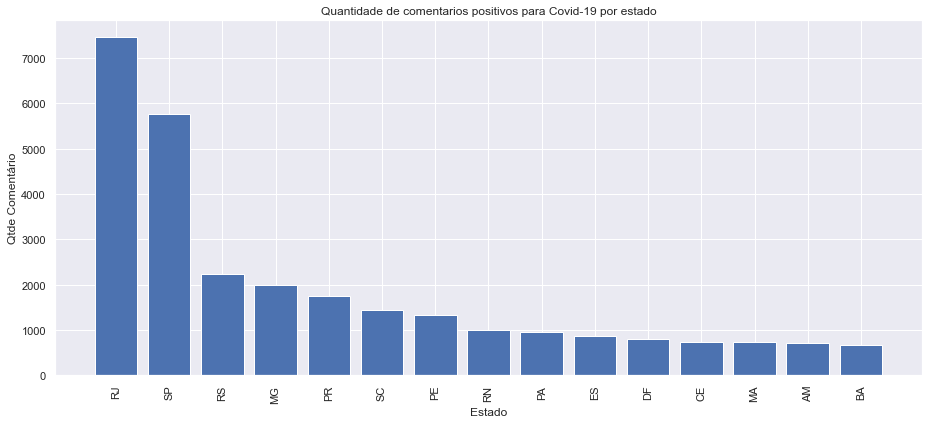

In [92]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(13, 6))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Qtde Comentário")
plt.tight_layout()
plt.show()

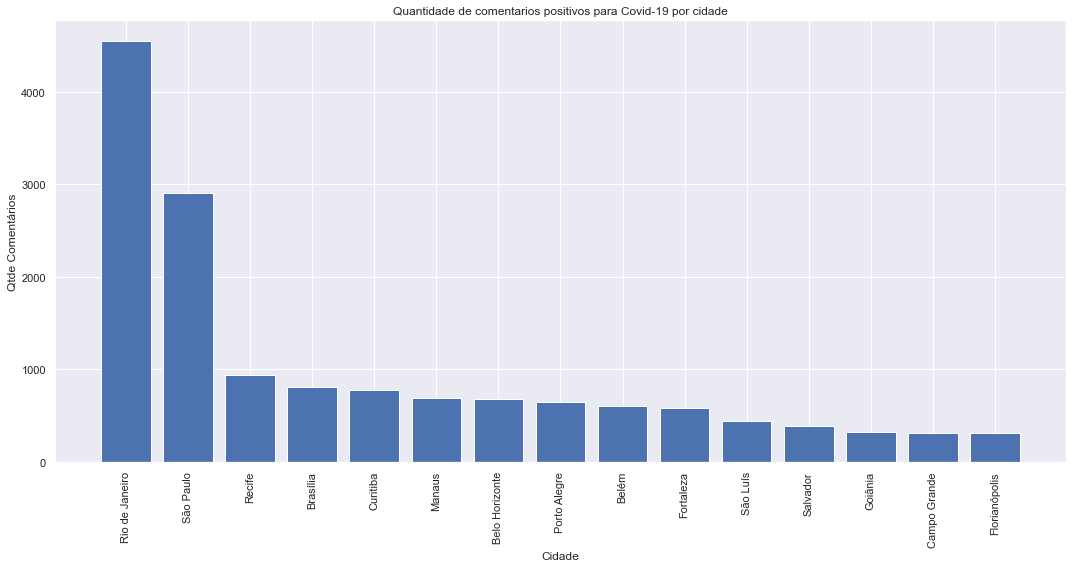

In [93]:
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

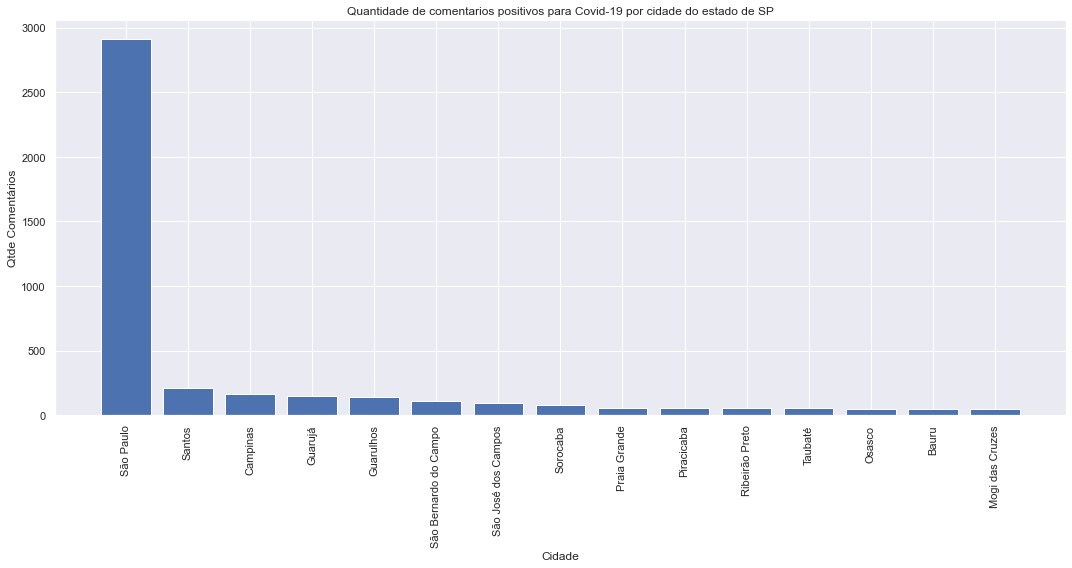

In [94]:
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
usr = usr[usr['state'] == 'SP']
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade do estado de SP")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

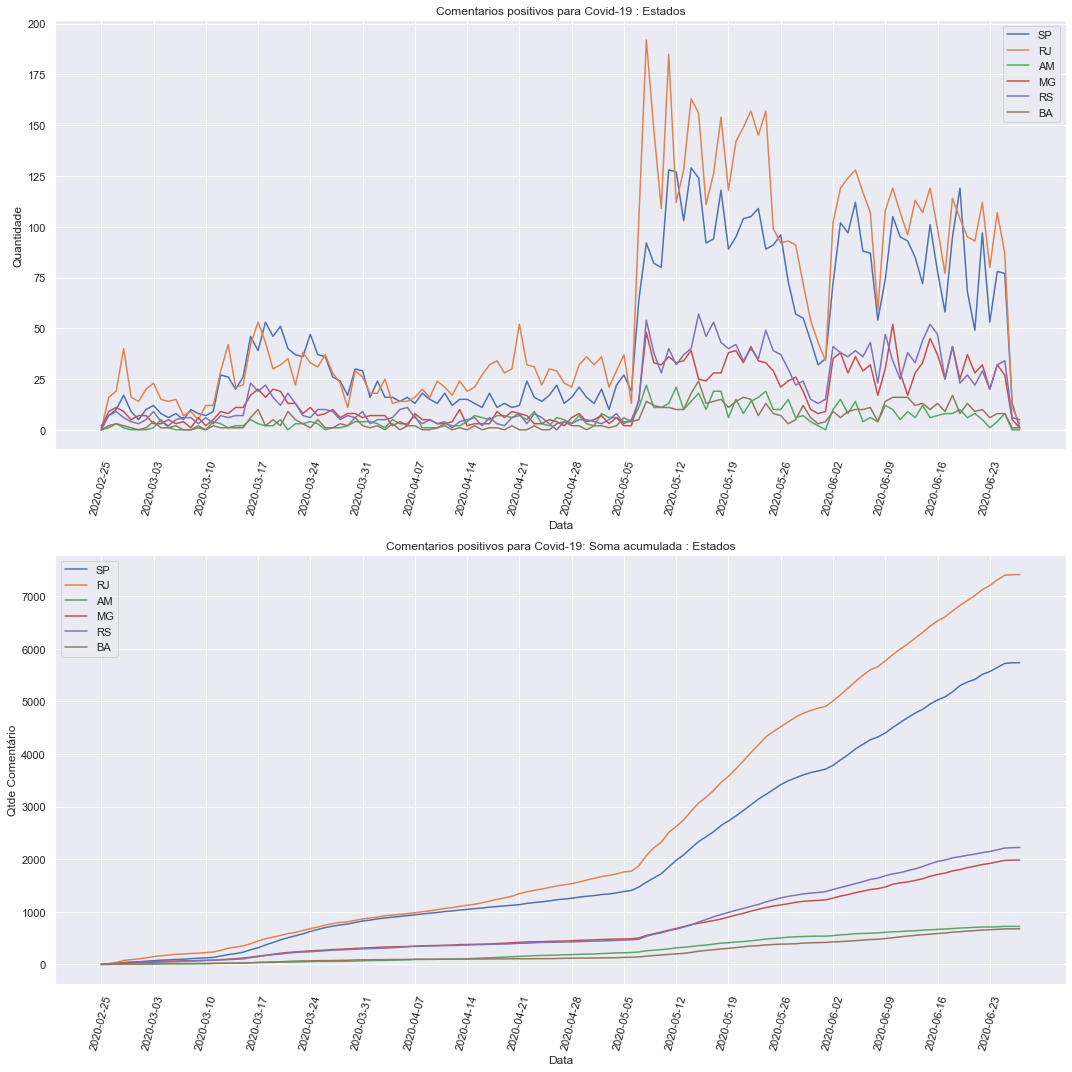

In [95]:
steps = 7

usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)

datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo
data_tempo = list(datas[::steps])

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Qtde Comentário")
plt.legend()
plt.tight_layout()
plt.show()